In [30]:
from UTILITY_quickstart import *
import yaml

with open('setLattice_defaults.yml', 'r') as file:
    importedDefaultSettings = yaml.safe_load(file)

In [31]:
tao = initializeTao(
    inputBeamFilePathSuffix = '/beams/nmmToL0AFEND_2bunch_2024-02-16Clean/2024-02-16_2bunch_1e5Downsample_nudgeWeights.h5',
    #inputBeamFilePathSuffix = '/beams/L0AFEND_facet2-lattice.h5',

    csrTF = True,
    numMacroParticles=1e4,
    #loadDefaultLatticeTF=False,


)

Environment set to:  /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao
Tracking to end
CSR on
Overwriting lattice with setLattice() defaults
No defaults file provided to setLattice(). Using setLattice_defaults.yml
Number of macro particles = 10000.0


In [3]:
tao.cmd("set ele XTCAVF VOLTAGE = 0e6")
tao.cmd(f"set ele XTCAVF PHI0 = {0/360.0}")

trackBeam(tao)

In [4]:
savedData = {}

P = getBeamAtElement(tao, "DTOTR")
PDrive, PWitness = getDriverAndWitness(P)


for PActiveStr in ["PDrive", "PWitness"]:
    PActive = locals()[PActiveStr]
    for val in ["mean_x", "mean_y", "mean_xp", "mean_yp", "sigma_x", "sigma_y"]:
        savedData[f"{PActiveStr}_{val}"] = PActive[val]
        #print(f"""{PActiveStr}_{val} = {PActive[val]}""")

    #Note that this is not a standard deviation; also imposes cost for being off zero
    savedData[f"{PActiveStr}_xCost"] = np.sqrt(np.mean((PActive.x)**2))
    savedData[f"{PActiveStr}_yCost"] = np.sqrt(np.mean((PActive.y)**2))


    #Using the product was making it report flat beams...
    #savedData[f"{PActiveStr}_totalCost"] = savedData[f"{PActiveStr}_xCost"] * savedData[f"{PActiveStr}_yCost"]
    #Instead, average
    savedData[f"{PActiveStr}_totalCost"] = 0.5*(savedData[f"{PActiveStr}_xCost"] + savedData[f"{PActiveStr}_yCost"])

    savedData[f"{PActiveStr}_emitSI90_x"] = smallestIntervalImpliedEmittance(PActive, plane = "x", percentage = 0.90)
    savedData[f"{PActiveStr}_emitSI90_y"] = smallestIntervalImpliedEmittance(PActive, plane = "y", percentage = 0.90)

    savedData[f"{PActiveStr}_zLen"] = smallestIntervalImpliedSigma(PActive.t * 3e8, percentage=0.9)

    savedData[f"{PActiveStr}_zCentroid"] = np.median(PActive.t * 3e8)

savedData["bunchSpacing"] = savedData["PWitness_zCentroid"] - savedData["PDrive_zCentroid"]

/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:178: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


In [5]:
savedData

{'PDrive_mean_x': 9.658276721430954e-06,
 'PDrive_mean_y': -0.0003728970340687463,
 'PDrive_mean_xp': 4.2041964127648e-06,
 'PDrive_mean_yp': -3.899356575925067e-05,
 'PDrive_sigma_x': 0.00017239541600845709,
 'PDrive_sigma_y': 0.0006390691027929406,
 'PDrive_xCost': 0.00017266575158367888,
 'PDrive_yCost': 0.00073990642392254,
 'PDrive_totalCost': 0.00045628608775310944,
 'PDrive_emitSI90_x': 7.904978651016961e-05,
 'PDrive_emitSI90_y': 0.0004273968155576781,
 'PDrive_zLen': 2.1437992861915576e-05,
 'PDrive_zCentroid': 1012.736519534956,
 'PWitness_mean_x': 0.0013337409720507124,
 'PWitness_mean_y': -0.0016064194917577348,
 'PWitness_mean_xp': 0.00018754182992661736,
 'PWitness_mean_yp': -0.00017226942083576458,
 'PWitness_sigma_x': 0.0006987374373251019,
 'PWitness_sigma_y': 0.00025948063569592686,
 'PWitness_xCost': 0.0015056888745177174,
 'PWitness_yCost': 0.0016272411572352582,
 'PWitness_totalCost': 0.0015664650158764878,
 'PWitness_emitSI90_x': 9.982156695089432e-05,
 'PWitness_

In [6]:
print(f"""Bunch spacing: \t\t{1e6 * savedData["bunchSpacing"] :.3g} um""")

print(f"""Transverse offset: \t{1e6*np.sqrt((savedData["PDrive_mean_x"] - savedData["PWitness_mean_x"])**2 + (savedData["PDrive_mean_y"] - savedData["PWitness_mean_y"])**2) :.3g} um""")

print("\nEmittances and sigmas - implied by 90% charge")
print(f"""Driver emittance: \t{1e6 * savedData["PDrive_emitSI90_x"] :.3g} × {1e6 * savedData["PDrive_emitSI90_y"] :.3g} um-rad""")
print(f"""Witness emittance: \t{1e6 * savedData["PWitness_emitSI90_x"] :.3g} × {1e6 * savedData["PWitness_emitSI90_y"] :.3g} um-rad""")

print(f"""Driver sigma_z: \t{1e6 * savedData["PDrive_zLen"] :.3g} um""")
print(f"""Witness sigma_z: \t{1e6 * savedData["PWitness_zLen"] :.3g} um""")

print("\nEmittances and sigmas - literal standard deviation")

print(f"""Driver emittance: \t{1e6 * PDrive["norm_emit_x"] :.3g} × {1e6 * PDrive["norm_emit_y"] :.3g} um-rad""")
print(f"""Witness emittance: \t{1e6 * PWitness["norm_emit_x"] :.3g} × {1e6 * PWitness["norm_emit_y"] :.3g} um-rad""")

print(f"""Driver sigma_x,y,z: \t{1e6 * PDrive["sigma_x"] :.3g}, {1e6 * PDrive["sigma_y"] :.3g}, {1e6 * PDrive["sigma_z"] :.3g} um""")
print(f"""Witness sigma_x,y,z: \t{1e6 * PWitness["sigma_x"] :.3g}, {1e6 * PWitness["sigma_y"] :.3g}, {1e6 * PWitness["sigma_z"] :.3g} um""")

print(f"""\nSurviving charge @ DTOTR: {100*(getBeamAtElement(tao, "DTOTR")).charge / 2.1e-9 : .3g}%""")

Bunch spacing: 		206 um
Transverse offset: 	1.81e+03 um

Emittances and sigmas - implied by 90% charge
Driver emittance: 	79 × 427 um-rad
Witness emittance: 	99.8 × 109 um-rad
Driver sigma_z: 	21.4 um
Witness sigma_z: 	18.7 um

Emittances and sigmas - literal standard deviation
Driver emittance: 	135 × 509 um-rad
Witness emittance: 	128 × 158 um-rad
Driver sigma_x,y,z: 	172, 639, 32.7 um
Witness sigma_x,y,z: 	699, 259, 20.8 um

Surviving charge @ DTOTR:  100%


In [7]:
print(f"""Driver sigma_x,y,z: \t{1e6 * PDrive["sigma_x"] :.3g}, {1e6 * PDrive["sigma_y"] :.3g}, {1e6 * PDrive["sigma_z"] :.3g} um""")
print(f"""Combined sigma_x,y,z: \t{1e6 * P["sigma_x"] :.3g}, {1e6 * P["sigma_y"] :.3g}, {1e6 * P["sigma_z"] :.3g} um""")

Driver sigma_x,y,z: 	172, 639, 32.7 um
Combined sigma_x,y,z: 	675, 777, 87.1 um


Drive:


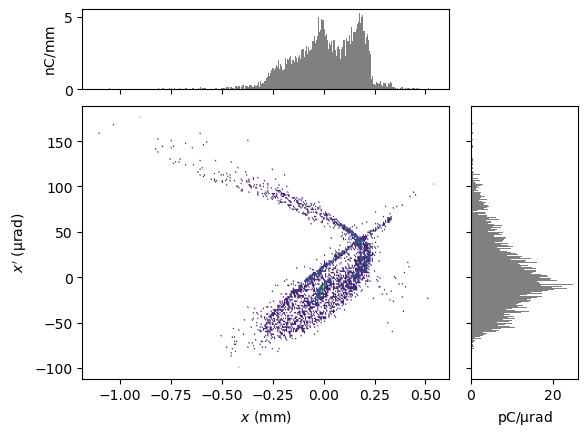

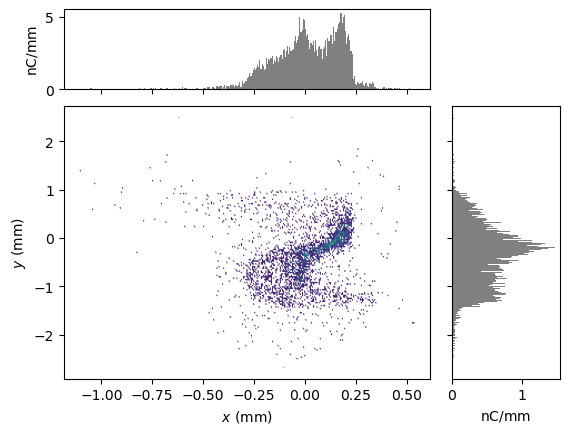

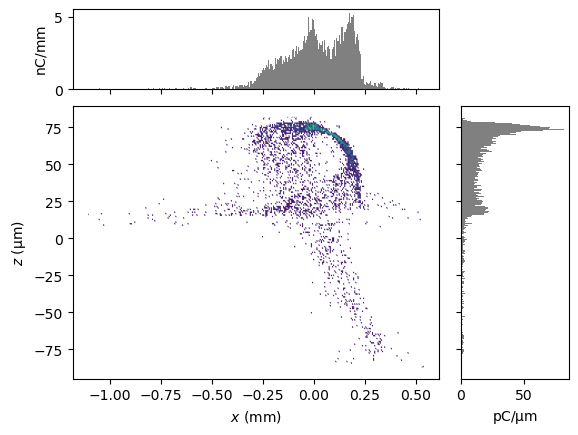

Both:


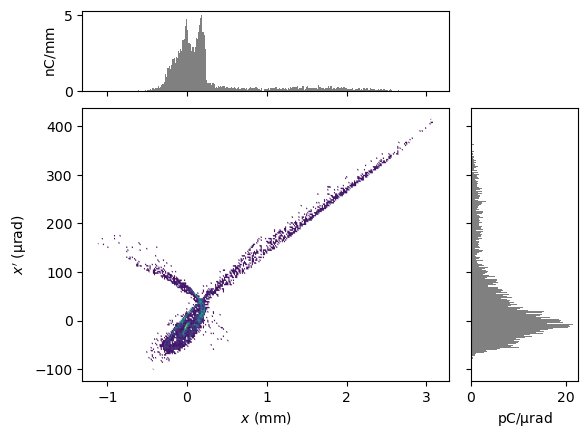

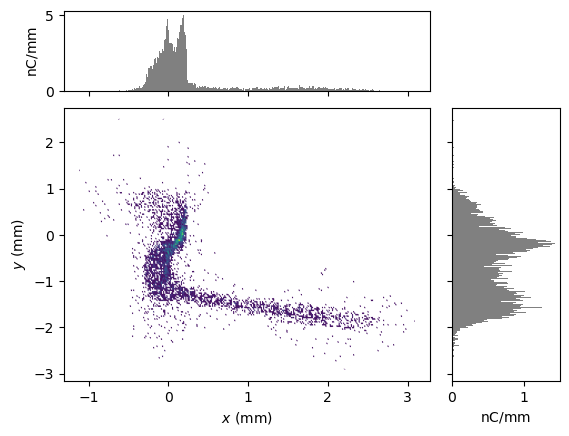

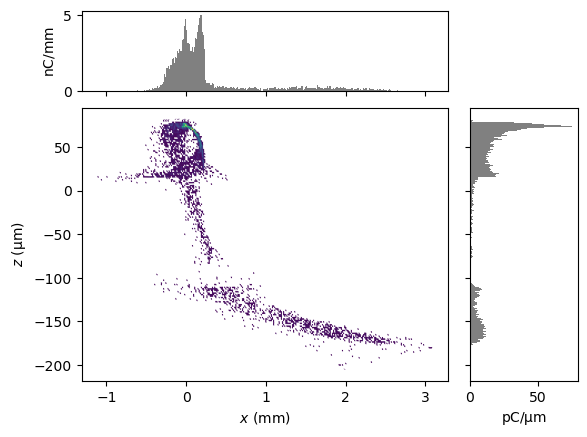

<Figure size 640x480 with 0 Axes>

In [8]:
print("Drive:")
display(plotMod(PDrive, 'x', 'xp',  bins=300))
display(plotMod(PDrive, 'x', 'y',  bins=300))
display(plotMod(PDrive, 'x', 'z',  bins=300))

print("Both:")
display(plotMod(P, 'x', 'xp',  bins=300))
display(plotMod(P, 'x', 'y',  bins=300))
display(plotMod(P, 'x', 'z',  bins=300))

plt.clf()

In [9]:
tao.cmd("set ele XTCAVF VOLTAGE = 10e6")
tao.cmd(f"set ele XTCAVF PHI0 = {0/360.0}")

trackBeam(tao)

In [10]:
P = getBeamAtElement(tao, "DTOTR")
PDrive, PWitness = getDriverAndWitness(P)

In [11]:
print(f"""Driver sigma_x,y,z: \t{1e6 * PDrive["sigma_x"] :.3g}, {1e6 * PDrive["sigma_y"] :.3g}, {1e6 * PDrive["sigma_z"] :.3g} um""")
print(f"""Combined sigma_x,y,z: \t{1e6 * P["sigma_x"] :.3g}, {1e6 * P["sigma_y"] :.3g}, {1e6 * P["sigma_z"] :.3g} um""")

Driver sigma_x,y,z: 	298, 644, 32.9 um
Combined sigma_x,y,z: 	1.2e+03, 771, 87.8 um


Drive:


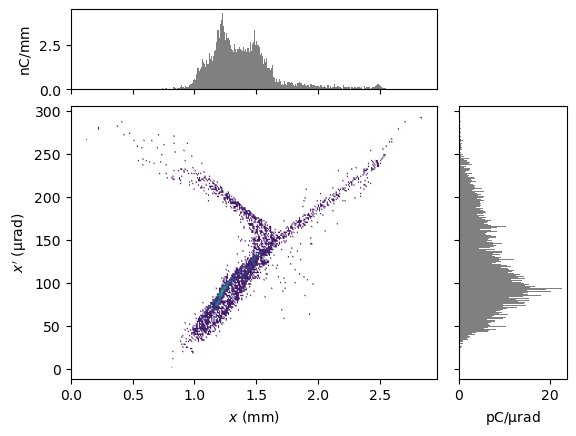

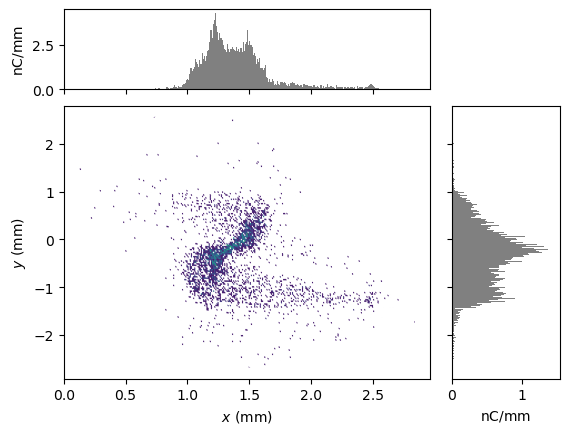

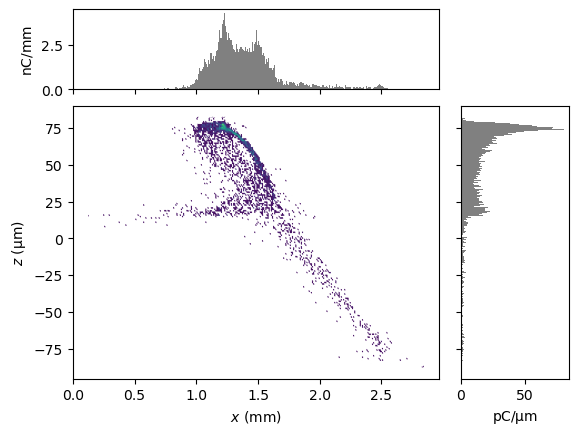

Both:


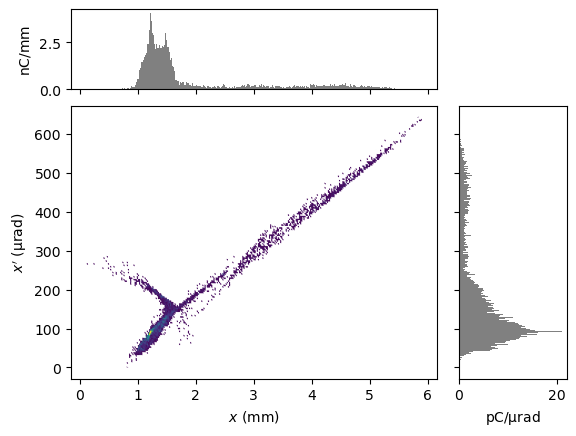

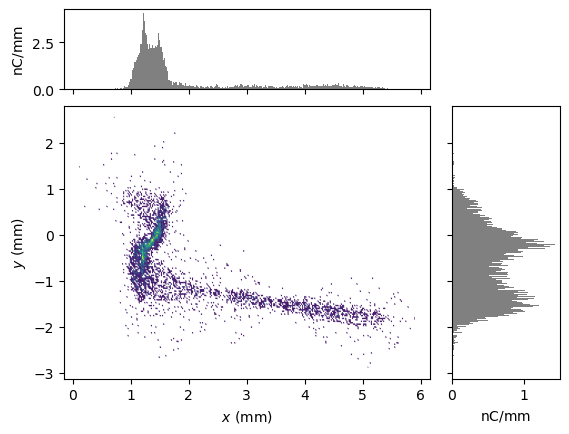

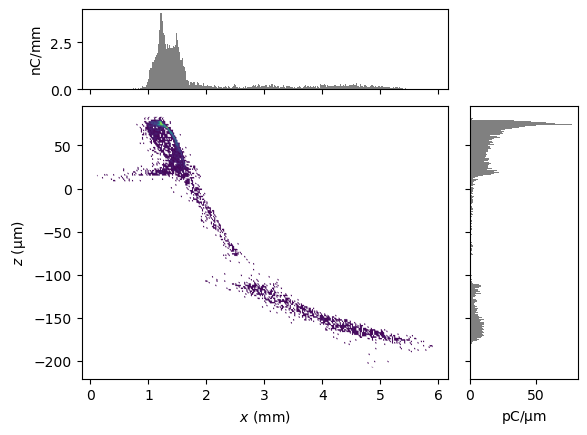

In [12]:
print("Drive:")
display(plotMod(PDrive, 'x', 'xp',  bins=300))
display(plotMod(PDrive, 'x', 'y',  bins=300))
display(plotMod(PDrive, 'x', 'z',  bins=300))

print("Both:")
display(plotMod(P, 'x', 'xp',  bins=300))
display(plotMod(P, 'x', 'y',  bins=300))
display(plotMod(P, 'x', 'z',  bins=300))

plt.clf()

In [13]:
tao.cmd("show ele S1EL -all")

['Element # 1764',
 'Element Name: S1EL',
 'Element Type:  "1.625S9.06"',
 'Key: Sextupole',
 'S_start, S:    943.163262,    943.413262',
 'Ref_time_start, Ref_time:  3.146071E-06,  3.146905E-06',
 '',
 'Attribute values:',
 '    1  L                           =  2.5000000E-01 m',
 '    2  TILT                        =  0.0000000E+00 rad      60  TILT_TOT                    =  0.0000000E+00 rad',
 '    5  K2                          =  1.2810324E+01 1/m^3    46  B2_GRADIENT                 = -4.2723956E+02 T/m^2',
 '   10  FRINGE_TYPE                 =  None (1)               11  FRINGE_AT                   =  Both_Ends (3)',
 '   13  SPIN_FRINGE_ON              =  T (1)',
 '   16  R0_MAG                      =  0.0000000E+00 m        15  R0_ELEC                     =  0.0000000E+00 m',
 '   17  STATIC_LINEAR_MAP           =  F (0)',
 '   34  X_PITCH                     =  0.0000000E+00 rad      55  X_PITCH_TOT                 =  0.0000000E+00 rad',
 '   35  Y_PITCH                    